# Exploratory data analysis of the MIT-BIH Arrhythmia Database

After installing the provided utility, you can first (for reproducibility) download the data using the CLI tool:

```bash
volta_download_data
```
This will automatically download the daya in `./data/mitdb`. You can also get the path using the `voltatest` provided package.

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# Ge download path for the MIT-BIH Arrhythmia Database
from voltatest.download import dl_dir
dl_dir

PosixPath('/Users/ssilvari/PycharmProjects/volta-test/data/mitdb')

## Understanding data structure
According to the [documentation](https://physionet.org/content/mitdb/1.0.0/), each ECG contains two channels. For QC. let's verify that this is the case.

In [98]:
# Importing the data
from voltatest.data import MITBIHDataset

dataset = MITBIHDataset(dl_dir=dl_dir)

print(f'Total number of ECGs: {len(dataset)}')

Total number of ECGs: 48


However, according to the Database docs, only 25 are complete. Let's see the sample distribution.

In [4]:
import pandas as pd

records_info = []
for record, annotation in dataset:
    records_info.append({
        'record': record.record_name,
        'record_length': len(record.p_signal),
        'channels': record.n_sig,
        'sampling_rate': record.fs,
        'annotation_length': len(annotation.sample)
    })

records_info = pd.DataFrame(records_info)

In [5]:
records_info

,record,record_length,channels,sampling_rate,annotation_length
0,213,650000,2,360,3294
1,207,650000,2,360,2385
2,212,650000,2,360,2763
3,210,650000,2,360,2685
4,205,650000,2,360,2672
5,201,650000,2,360,2039
6,215,650000,2,360,3400
7,214,650000,2,360,2297
8,200,650000,2,360,2792
9,228,650000,2,360,2141


<Axes: xlabel='sampling_rate', ylabel='record'>

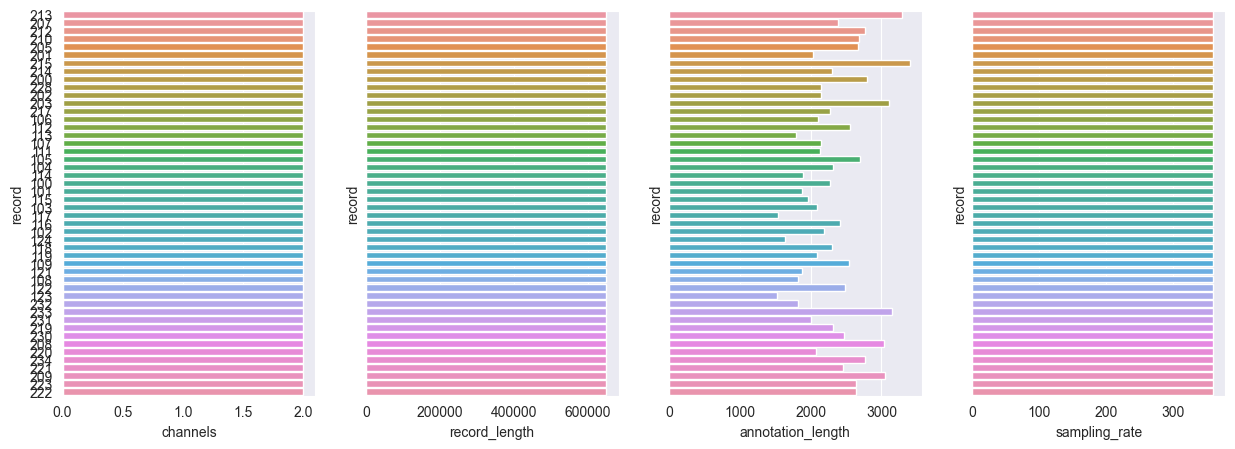

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
# Plot the number of channels per each record
sns.barplot(y='record', x='channels', data=records_info, ax=axs[0])

# Plot the number of samples per each record
sns.barplot(y='record', x='record_length', data=records_info, ax=axs[1])

# Number of annotations per each record
sns.barplot(y='record', x='annotation_length', data=records_info, ax=axs[2])

# Sampling rate per each record
sns.barplot(y='record', x='sampling_rate', data=records_info, ax=axs[3])

This allows us to see that the dataset is clean and that we must choose a method that

Record Name                 215
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      3400


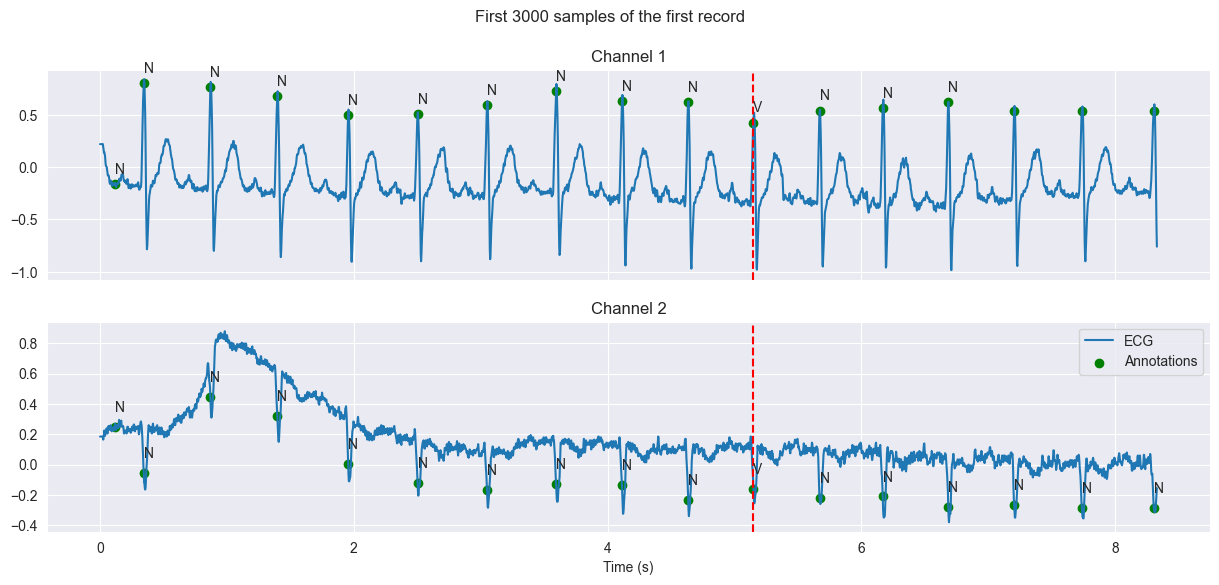

In [217]:
import os
# Plotting the first 3000 samples of the first record
import random

# Use our coded visualization tool
from voltatest.visualize import plot_first_n_samples

# random.seed(42) # For reproducibility

# Choose random record
record, annotation = random.choice(dataset)

plot_first_n_samples(record, annotation, n_samples=3000)
fig_dir = os.path.expanduser(f'~/Downloads/first_3000_samples_{record.record_name}.png')
plt.savefig(fig_dir, dpi=300, bbox_inches='tight')
plt.show()


The vertical lines highlight the abnormal annotations. Let's see the distribution of the annotations.

In [8]:
import pandas as pd

annotations_dataset = []

for _, annotation in dataset:
    for i, sample_idx in enumerate(annotation.sample):
        data = {
            'record_name': annotation.record_name,
            'symbol': annotation.symbol[i],
            'index': sample_idx
        }
        annotations_dataset.append(data)

annot_df = pd.DataFrame(annotations_dataset)

In [9]:
print(annot_df.symbol.value_counts().to_markdown())

| symbol   |   count |
|:---------|--------:|
| N        |   75052 |
| L        |    8075 |
| R        |    7259 |
| V        |    7130 |
| /        |    7028 |
| A        |    2546 |
| +        |    1291 |
| f        |     982 |
| F        |     803 |
| ~        |     616 |
| !        |     472 |
| "        |     437 |
| j        |     229 |
| x        |     193 |
| a        |     150 |
| |        |     132 |
| E        |     106 |
| J        |      83 |
| Q        |      33 |
| e        |      16 |
| ]        |       6 |
| [        |       6 |
| S        |       2 |


According to the annotation list, this dataset contains the following annotations [source](https://archive.physionet.org/physiobank/annotations.shtml):



In [63]:
meanings = {
    "N": "Normal beat (displayed as '·' by the PhysioBank ATM, LightWAVE, pschart, and psfd)",
    "L": "Left bundle branch block beat",
    "R": "Right bundle branch block beat",
    "B": "Bundle branch block beat (unspecified)",
    "A": "Atrial premature beat",
    "a": "Aberrated atrial premature beat",
    "J": "Nodal (junctional) premature beat",
    "S": "Supraventricular premature or ectopic beat (atrial or nodal)",
    "V": "Premature ventricular contraction",
    "r": "R-on-T premature ventricular contraction",
    "F": "Fusion of ventricular and normal beat",
    "e": "Atrial escape beat",
    "j": "Nodal (junctional) escape beat",
    "n": "Supraventricular escape beat (atrial or nodal)",
    "E": "Ventricular escape beat",
    "/": "Paced beat",
    "f": "Fusion of paced and normal beat",
    "Q": "Unclassifiable beat",
    "?": "Beat not classified during learning",
    "[": "Start of ventricular flutter/fibrillation",
    "!": "Ventricular flutter wave",
    "]": "End of ventricular flutter/fibrillation",
    "x": "Non-conducted P-wave (blocked APC)",
    "(": "Waveform onset",
    ")": "Waveform end",
    "p": "Peak of P-wave",
    "t": "Peak of T-wave",
    "u": "Peak of U-wave",
    "`": "PQ junction",
    "'": "J-point",
    "^": "(Non-captured) pacemaker artifact",
    "|": "Isolated QRS-like artifact",
    "~": "Change in signal quality",
    "+": "Rhythm change",
    "s": "ST segment change",
    "T": "T-wave change",
    "*": "Systole",
    "D": "Diastole",
    "=": "Measurement annotation",
    "\"": "Comment annotation",
    "@": "Link to external data"
}

In [67]:
annot_df['Description'] = annot_df['symbol'] + ' - ' + annot_df['symbol'].map(lambda x: meanings.get(x, 'Unknown'))
print(annot_df['Description'].value_counts(dropna=False).to_markdown())

| Description                                                                            |   count |
|:---------------------------------------------------------------------------------------|--------:|
| N - Normal beat (displayed as '·' by the PhysioBank ATM, LightWAVE, pschart, and psfd) |   75052 |
| L - Left bundle branch block beat                                                      |    8075 |
| R - Right bundle branch block beat                                                     |    7259 |
| V - Premature ventricular contraction                                                  |    7130 |
| / - Paced beat                                                                         |    7028 |
| A - Atrial premature beat                                                              |    2546 |
| + - Rhythm change                                                                      |    1291 |
| f - Fusion of paced and normal beat                                                    | 

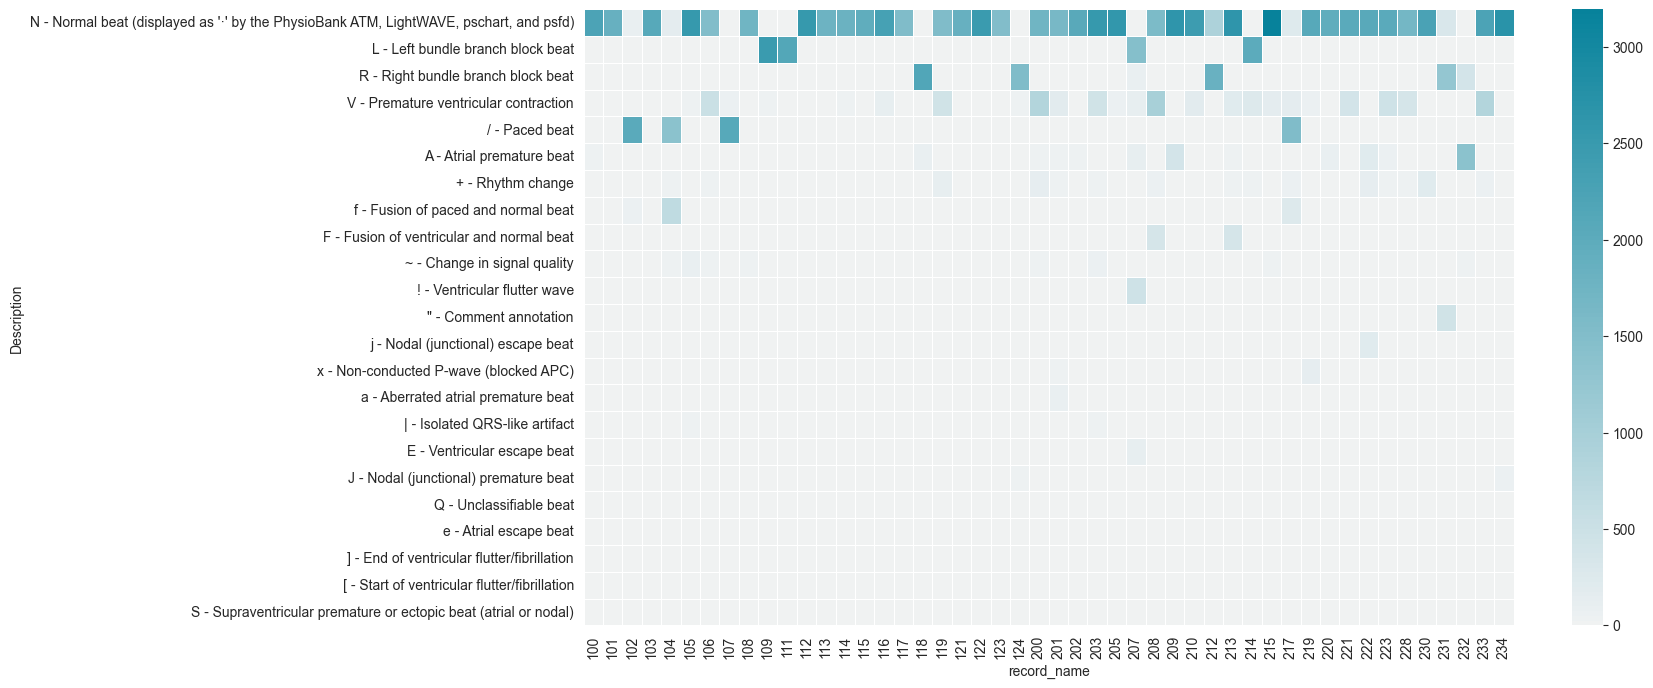

In [68]:
import numpy as np
order = annot_df['Description'].value_counts().index # Order frequency wise (desc)
cross_tab_annot_freq = pd.crosstab(annot_df['Description'], annot_df['record_name']).loc[order]

palette = sns.diverging_palette(10, 220, n=256, s=99, l=50, as_cmap=True)

plt.subplots(figsize=(15, 8))
ax = sns.heatmap(cross_tab_annot_freq, vmin=0, linewidths=0.5, center=0, cmap=palette)

In [69]:
print(f'Total number of classes:', len(annot_df.Description.unique()))

Total number of classes: 23


## Select only annotations that are of interest

The problem focuses on atrial fibrillation (AFIB) and atrial flutter (AFL) rhythms.
According to the original paper, the authors used the following rhythm onset annotations (annotation code 28 - `ONSET`).

This information is in the auxiliary note field of the annotation object (kind of tricky to find).


In [74]:
annotation.sample[annotation.subtype == 28]

array([], dtype=int64)

In [79]:
idxs = [i for i, x in enumerate(annotation.aux_note) if str(x).startswith('(')]
aux_notes = [annotation.aux_note[i] for i in idxs]
aux_notes

['(N\x00',
 '(VT\x00',
 '(N\x00',
 '(T\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(VT\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(VT\x00',
 '(N\x00',
 '(VT\x00',
 '(N\x00',
 '(VT\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00',
 '(VT\x00',
 '(N\x00',
 '(B\x00',
 '(N\x00']

In [80]:
[annotation.symbol[i] for i in idxs]

['+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+']

## Create dataset with AFIB and AFL annotations


First, we need to select the patients containing the corresponding annotations.

In [84]:
def is_onset_annotation_present(annotation, onset_ascii_code: str):
    return any([str(x).startswith(onset_ascii_code) for x in annotation.aux_note])

is_onset_annotation_present(annotation, '(B')

False

In [85]:
afib_subjects = []
afl_subjects = []

for record, annotation in dataset:
    if is_onset_annotation_present(annotation, '(AFIB'):
        afib_subjects.append(record.record_name)
    if is_onset_annotation_present(annotation, '(AFL'):
        afl_subjects.append(record.record_name)

print(f'Number of AFIB subjects: {len(afib_subjects)}')
print(f'Number of AFL subjects: {len(afl_subjects)}')

Number of AFIB subjects: 8
Number of AFL subjects: 3


In [86]:
afib_subjects, afl_subjects

(['210', '201', '202', '203', '217', '219', '221', '222'],
 ['202', '203', '222'])

Record Name                 210
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      2685
Record Name                 201
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      2039
Record Name                 202
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      2146
Record Name                 203
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      3108
Record Name                 217
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      2280
Record Name                 219
Length of Record         650000
Number of Channels            2
Sampling Rate               360
Number of Annotations      2312
Record Name                 221
Length o

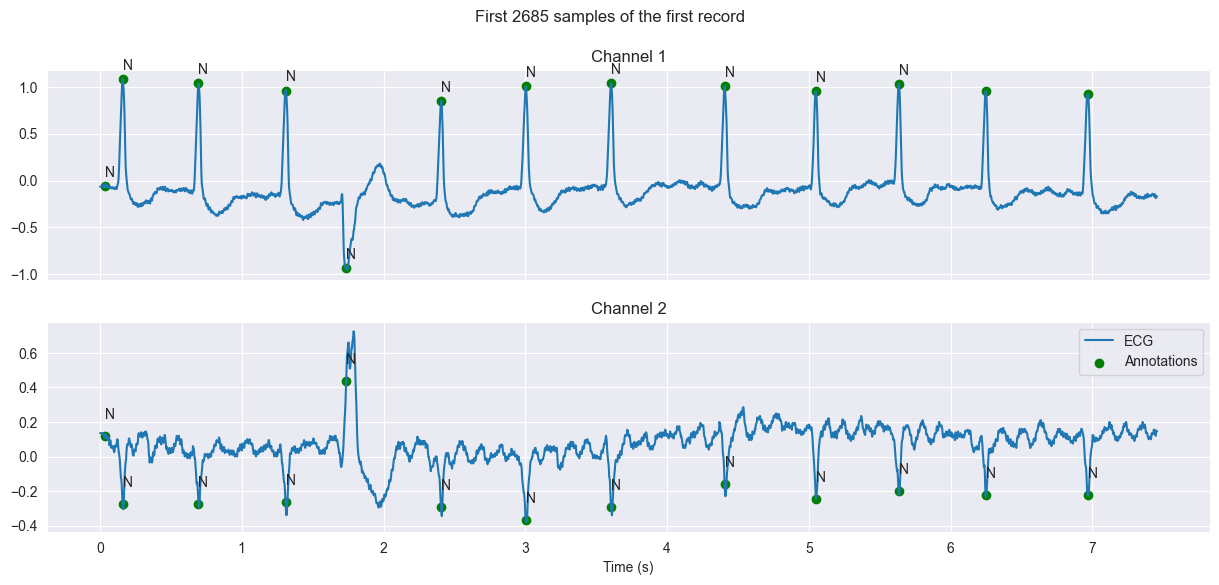

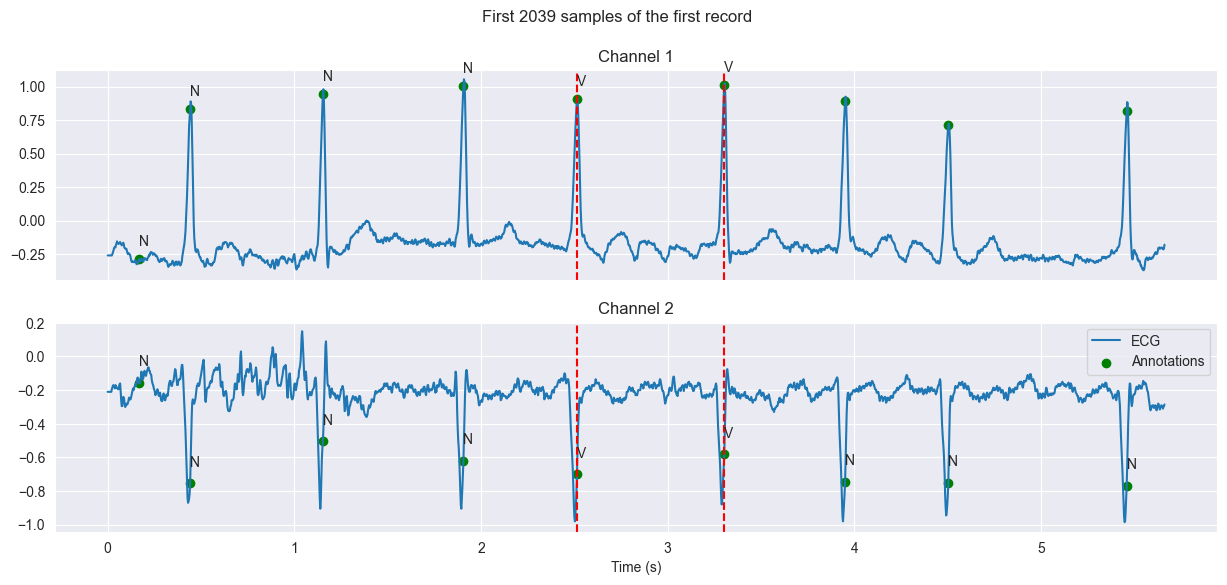

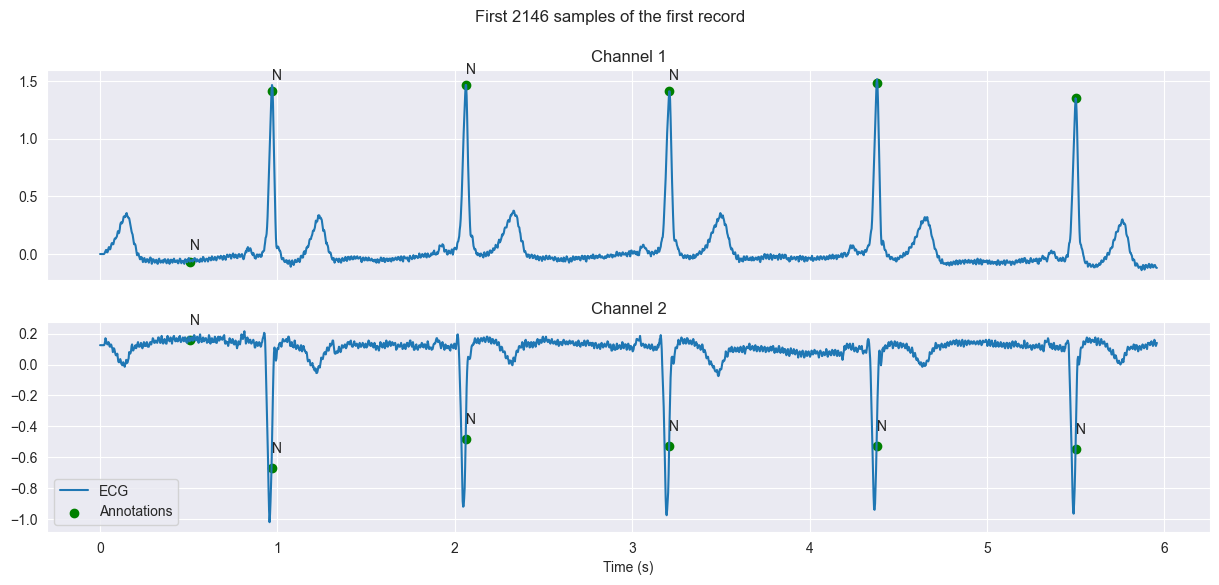

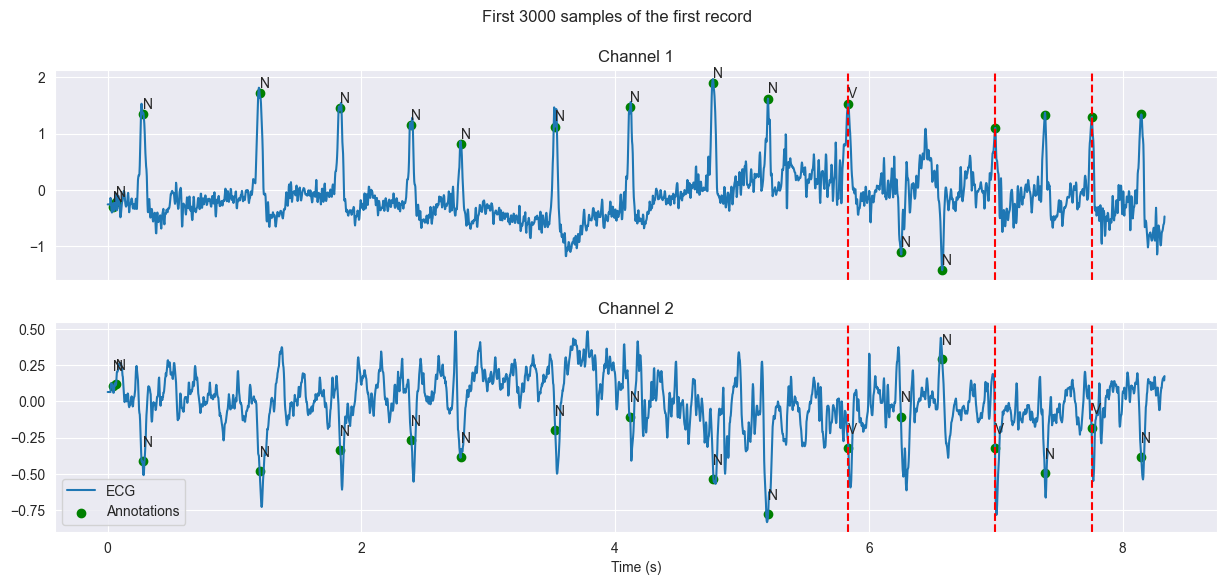

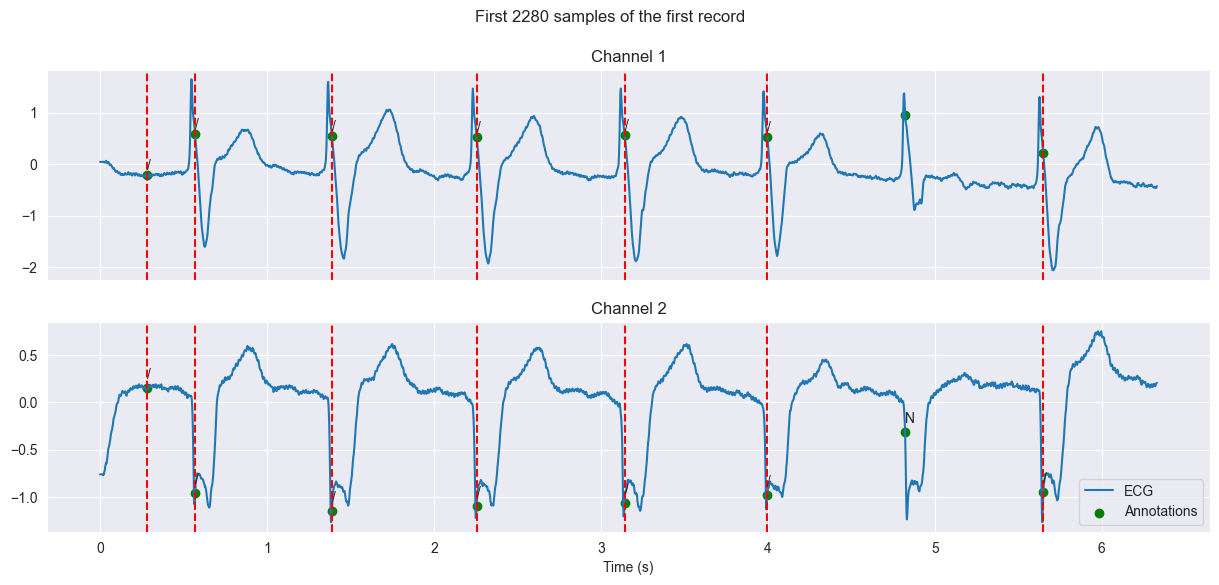

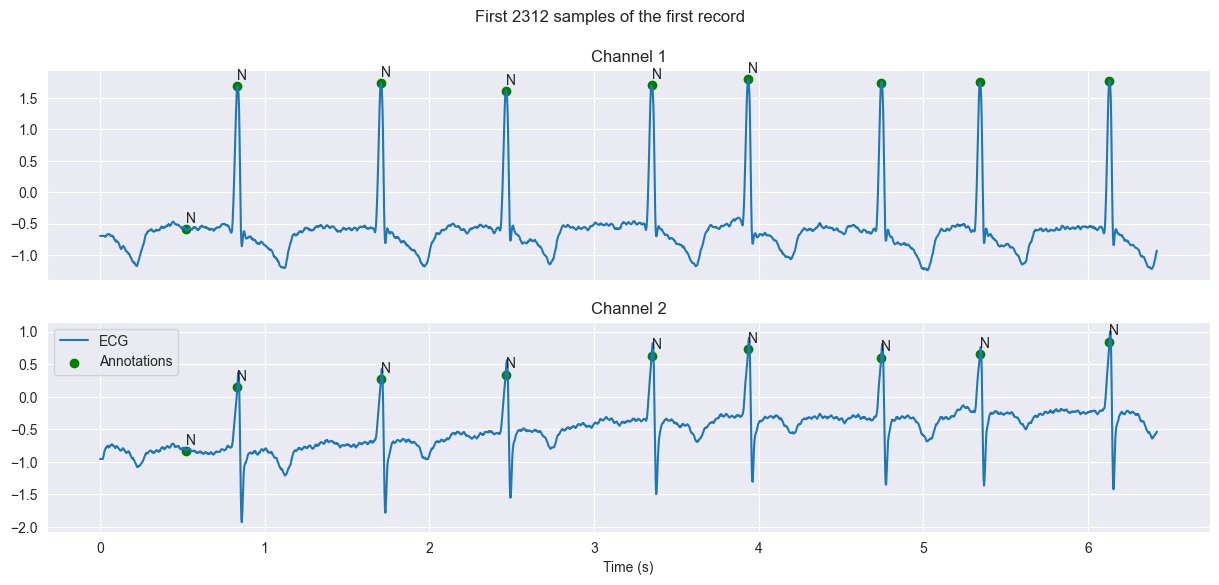

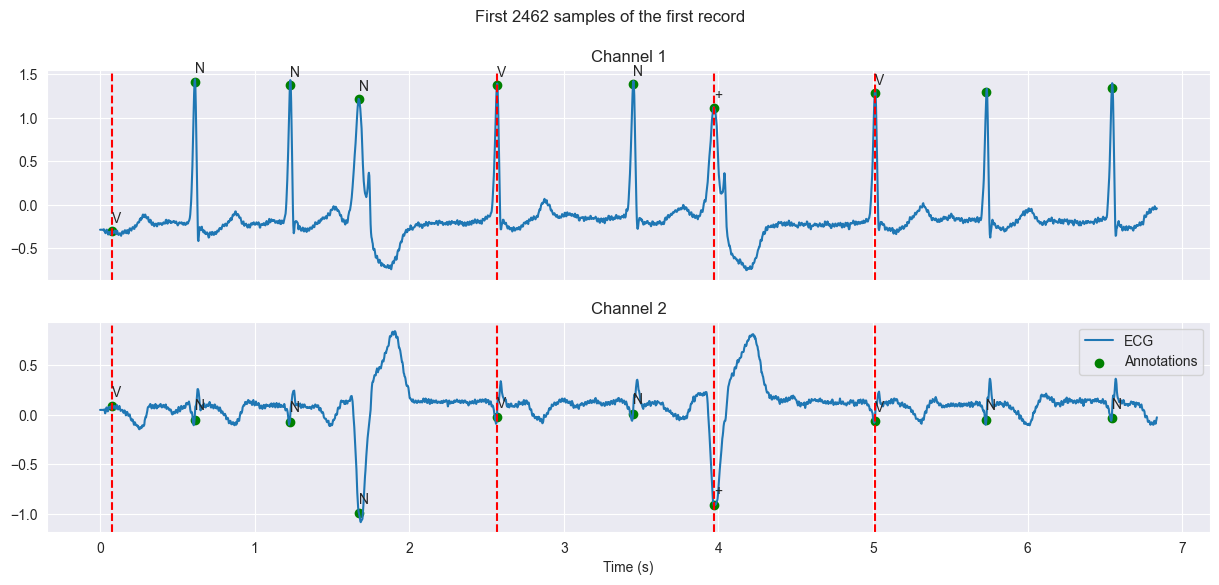

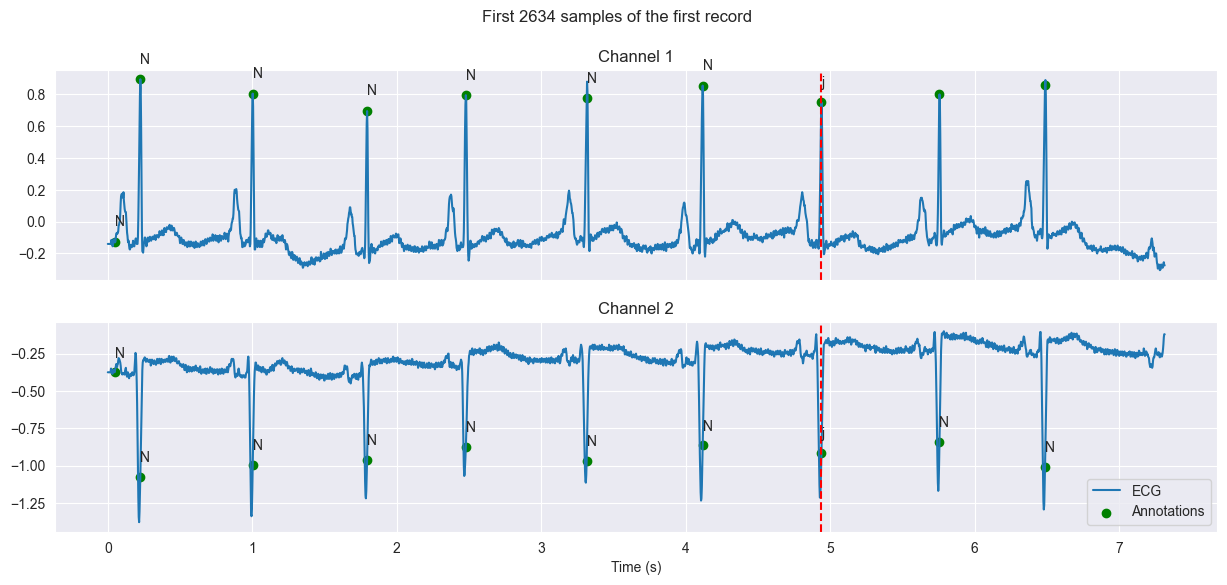

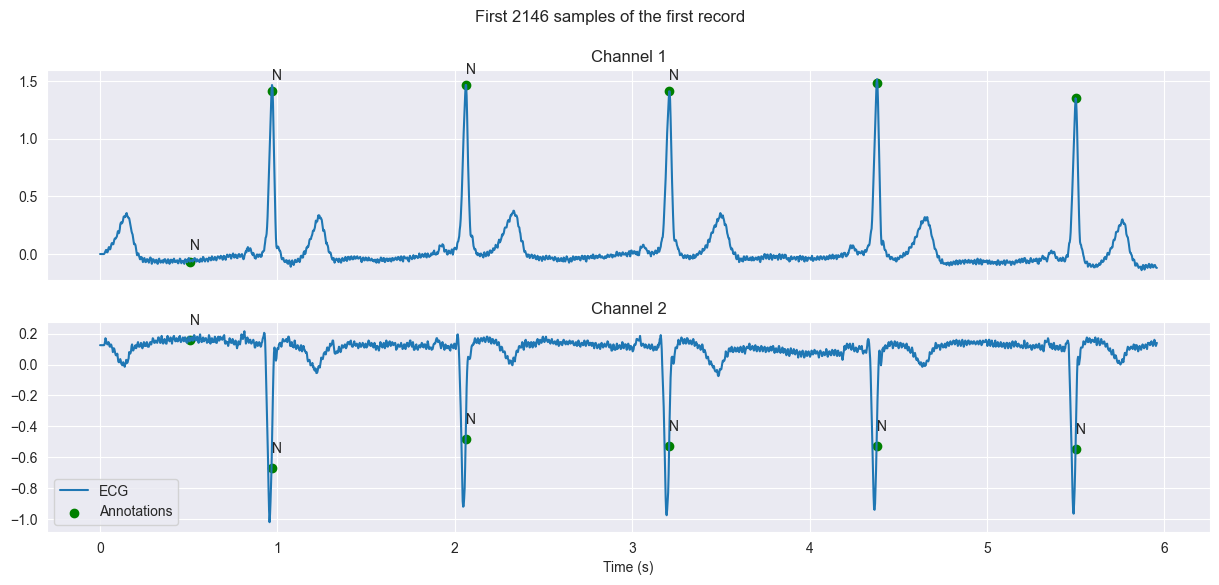

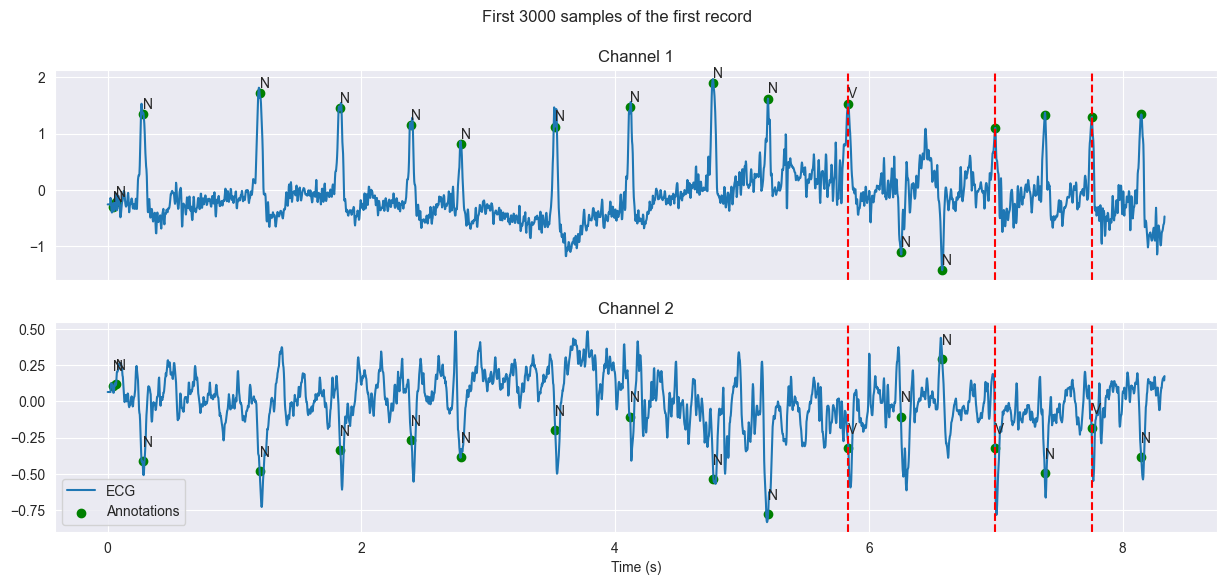

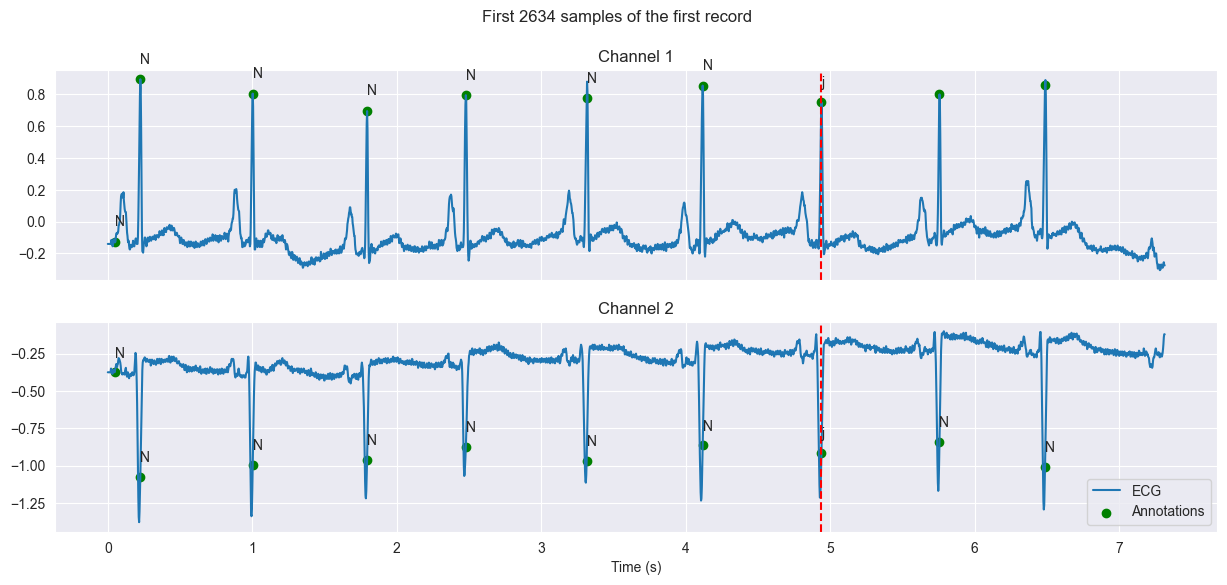

In [218]:
for subject_id in afib_subjects:
    record, annotation = dataset[subject_id]

    plot_first_n_samples(record, annotation, n_samples=3000)
    fig_dir = os.path.expanduser(f'~/Downloads/first_3000_samples_{record.record_name}_AFIB.png')
    plt.savefig(fig_dir, dpi=300, bbox_inches='tight')

for subject_id in afl_subjects:
    record, annotation = dataset[subject_id]

    plot_first_n_samples(record, annotation, n_samples=3000)
    fig_dir = os.path.expanduser(f'~/Downloads/first_3000_samples_{record.record_name}_AFL.png')
    plt.savefig(fig_dir, dpi=300, bbox_inches='tight')

## Data exploration on particular cases of interest

In [278]:
def ecg_as_dataframe(subject_id, mode='(AFIB', annot_idx=2):
    record_i, annot_i = dataset[subject_id]
    time_s = np.array(range(len(record_i.p_signal[:, 0]))) / record_i.fs
    time_hh_mm_ss = [datetime.timedelta(seconds=t) for t in time_s]

    data_i = pd.DataFrame({'Modified Lead II': record_i.p_signal[:, 0], 'V1': record_i.p_signal[:, 1], 'Time': time_hh_mm_ss})
    data_i['Subject'] = afib_subject

    for idx, symbol, aux_note in zip(annot_i.sample, annot_i.symbol, annot_i.aux_note):
            data_i.loc[idx, 'Aux. Note'] = aux_note.replace('\x00', '')
            data_i.loc[idx, 'Symbol'] = symbol
            data_i.loc[idx, 'Index'] = idx

    # Return from the first onset annotation
    print(data_i['Aux. Note'].value_counts(dropna=False).to_markdown())
    starting_index = data_i.query(f'`Aux. Note` == "{mode}"').index[annot_idx] - int(record.fs * 2.5)
    print(starting_index)
    data_i = data_i.loc[starting_index:]

    return data_i

In [289]:
import datetime
import neurokit2 as nk

data = []
for afib_subject in afib_subjects:
    print(afib_subject)
    data_i = ecg_as_dataframe(afib_subject)

    ecg_signals, info = nk.ecg_process(data_i["Modified Lead II"], sampling_rate=record.fs)

    nk.ecg_plot(ecg_signals[:record.fs * 5], sampling_rate=record.fs)
    fig = plt.gcf()
    fig.suptitle(f'ECG of subject {afib_subject}')
    ax = fig.get_axes()[0]

    # t = (data_i + record.fs * 7) / record.fs
    ax.axvline(x=2.5, color='blue', linestyle='--')  # Replace 0.5 with the desired x-coordinate)

    fig.set_size_inches(12, 6)  # Width: 10 inches, Height: 6 inches
    path = f'/Users/ssilvari/Downloads/AFIB/first_5000_samples_{afib_subject}_AFIB.png'
    print(f'Saving figure to {path}')
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.clf()
    plt.cla()
    plt.close('all')

    data.append(data_i)
    # break

data = pd.concat(data)
data.head(10)

210
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  647315 |
|             |    2668 |
| (AFIB       |       9 |
| (B          |       5 |
| (VT         |       2 |
| (T          |       1 |
217639
Saving figure to /Users/ssilvari/Downloads/AFIB/first_5000_samples_210_AFIB.png
201
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  647961 |
|             |    2004 |
| (N          |      16 |
| (T          |      12 |
| (AFIB       |       3 |
| (NOD        |       3 |
| (SVTA       |       1 |
573842
Saving figure to /Users/ssilvari/Downloads/AFIB/first_5000_samples_201_AFIB.png
202
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  647854 |
|             |    2138 |
| (AFIB       |       4 |
| (N          |       3 |
| (AFL        |       1 |
467778
Saving figure to /Users/ssilvari/Downloads/AFIB/first_5000_samples_202_AFIB.png
203
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  646892 |
|             |    30

,Modified Lead II,V1,Time,Subject,Aux. Note,Symbol,Index
217639,0.095,0.155,0 days 00:10:04.552778,210,NaN,NaN,NaN
217640,0.100,0.155,0 days 00:10:04.555556,210,NaN,NaN,NaN
217641,0.090,0.125,0 days 00:10:04.558333,210,NaN,NaN,NaN
217642,0.075,0.125,0 days 00:10:04.561111,210,NaN,NaN,NaN
217643,0.065,0.125,0 days 00:10:04.563889,210,NaN,NaN,NaN
217644,0.055,0.135,0 days 00:10:04.566667,210,NaN,NaN,NaN
217645,0.070,0.120,0 days 00:10:04.569444,210,NaN,NaN,NaN
217646,0.070,0.150,0 days 00:10:04.572222,210,NaN,NaN,NaN
217647,0.070,0.135,0 days 00:10:04.575000,210,NaN,NaN,NaN
217648,0.045,0.130,0 days 00:10:04.577778,210,NaN,NaN,NaN


/var/folders/s3/jph443dd1sx5dhwy6lsqp1x40000gn/T/ipykernel_1545/4241842253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_subjects['Aux. Note'] = normal_subjects['Symbol']


<Axes: xlabel='Aux. Note', ylabel='Subject'>

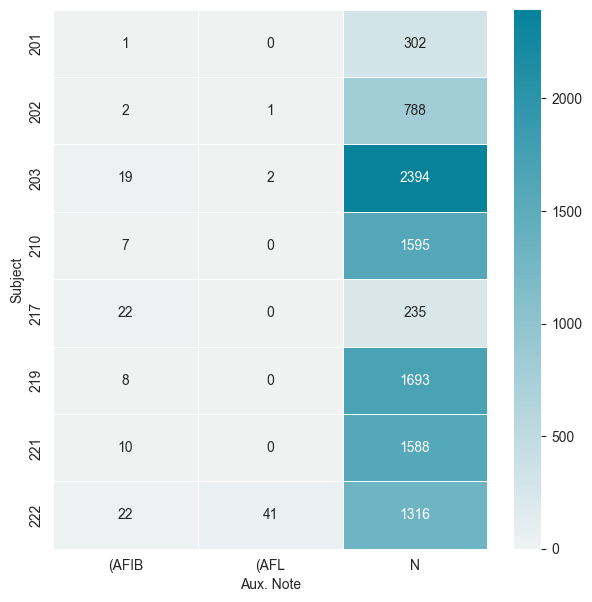

In [297]:
afibs = data.query('`Aux. Note` == "(AFIB"')
afl_subjects = data.query('`Aux. Note` == "(AFL"')
normal_subjects = data.query('`Symbol` == "N"')
normal_subjects['Aux. Note'] = normal_subjects['Symbol']
df_interested = pd.concat([afibs, afl_subjects, normal_subjects])

plt.subplots(figsize=(7, 7))
sns.heatmap(pd.crosstab(df_interested['Subject'], df_interested['Aux. Note']), vmin=0, linewidths=0.5, center=0, cmap=palette, annot=True, fmt='g')

In [287]:
import datetime
import neurokit2 as nk

data = []
for subject in afl_subjects:
    print(subject)
    data_i = ecg_as_dataframe(subject, mode='(AFL', annot_idx=-1)

    ecg_signals, info = nk.ecg_process(data_i["V1"] * -1, sampling_rate=record.fs)

    nk.ecg_plot(ecg_signals[:record.fs * 5], sampling_rate=record.fs)
    fig = plt.gcf()
    fig.suptitle(f'ECG of subject {subject}')
    ax = fig.get_axes()[0]

    # t = (data_i + record.fs * 7) / record.fs
    ax.axvline(x=2.5, color='blue', linestyle='--')  # Replace 0.5 with the desired x-coordinate)

    fig.set_size_inches(12, 6)  # Width: 10 inches, Height: 6 inches
    path = f'/Users/ssilvari/Downloads/AFL/first_5000_samples_{subject}_AFL.png'
    print(f'Saving figure to {path}')
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.clf()
    plt.cla()
    plt.close('all')

    data.append(data_i)
    # break

data = pd.concat(data)
data.head(10)

202
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  647854 |
|             |    2138 |
| (AFIB       |       4 |
| (N          |       3 |
| (AFL        |       1 |
548893
Saving figure to /Users/ssilvari/Downloads/AFL/first_5000_samples_202_AFL.png
203
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  646892 |
|             |    3063 |
| (AFIB       |      21 |
| (VT         |      21 |
| (AFL        |       2 |
| (T          |       1 |
280997
Saving figure to /Users/ssilvari/Downloads/AFL/first_5000_samples_203_AFL.png
222
| Aux. Note   |   count |
|:------------|--------:|
| nan         |  647366 |
|             |    2498 |
| (AFL        |      42 |
| (N          |      32 |
| (NOD        |      31 |
| (AFIB       |      24 |
| (SVTA       |       4 |
| (AB         |       3 |
597642
Saving figure to /Users/ssilvari/Downloads/AFL/first_5000_samples_222_AFL.png


,Modified Lead II,V1,Time,Subject,Aux. Note,Symbol,Index
548893,-0.180,0.160,0 days 00:25:24.702778,222,NaN,NaN,NaN
548894,-0.185,0.160,0 days 00:25:24.705556,222,NaN,NaN,NaN
548895,-0.175,0.165,0 days 00:25:24.708333,222,NaN,NaN,NaN
548896,-0.155,0.160,0 days 00:25:24.711111,222,NaN,NaN,NaN
548897,-0.165,0.135,0 days 00:25:24.713889,222,NaN,NaN,NaN
548898,-0.155,0.110,0 days 00:25:24.716667,222,NaN,NaN,NaN
548899,-0.160,0.105,0 days 00:25:24.719444,222,NaN,NaN,NaN
548900,-0.170,0.120,0 days 00:25:24.722222,222,NaN,NaN,NaN
548901,-0.160,0.105,0 days 00:25:24.725000,222,NaN,NaN,NaN
548902,-0.145,0.110,0 days 00:25:24.727778,222,NaN,NaN,NaN


In [167]:
data['Event'] = data['Aux. Note'].map(lambda x: x if str(x).startswith('(') else 'None')
data.head()

,Modified Lead II,V1,Time,Subject,Aux. Note,Symbol,Index,Event
0,-0.065,0.135,0 days 00:00:00,210,NaN,NaN,NaN,None
1,-0.065,0.135,0 days 00:00:00.002778,210,NaN,NaN,NaN,None
2,-0.065,0.135,0 days 00:00:00.005556,210,NaN,NaN,NaN,None
3,-0.065,0.135,0 days 00:00:00.008333,210,NaN,NaN,NaN,None
4,-0.065,0.135,0 days 00:00:00.011111,210,NaN,NaN,NaN,None


In [168]:
# Query events that are AFIB
data[data['Aux. Note'].str.startswith('(AFIB').fillna(False)]

,Modified Lead II,V1,Time,Subject,Aux. Note,Symbol,Index,Event
13,-0.055,0.120,0 days 00:00:00.036111,210,(AFIB ,+,13.0,(AFIB 
152488,-0.230,0.200,0 days 00:07:03.577778,210,(AFIB ,+,152488.0,(AFIB 
218539,-0.150,0.085,0 days 00:10:07.052778,210,(AFIB ,+,218539.0,(AFIB 
367320,0.005,0.045,0 days 00:17:00.333333,210,(AFIB ,+,367320.0,(AFIB 
370012,-0.035,-0.100,0 days 00:17:07.811111,210,(AFIB ,+,370012.0,(AFIB 
390958,-0.135,0.205,0 days 00:18:05.994444,210,(AFIB ,+,390958.0,(AFIB 
394037,0.025,0.170,0 days 00:18:14.547222,210,(AFIB ,+,394037.0,(AFIB 
400544,-0.100,0.015,0 days 00:18:32.622222,210,(AFIB ,+,400544.0,(AFIB 
598041,-0.205,0.085,0 days 00:27:41.225000,210,(AFIB ,+,598041.0,(AFIB 


In [195]:
import neurokit2 as nk

ecg_signals, info = nk.ecg_process(data["Modified Lead II"], sampling_rate=record.fs)
ecg_signals.head()

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.065,-0.020339,88.100574,0.96735,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-0.065,-0.020274,88.100574,0.96735,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-0.065,-0.019799,88.100574,0.96735,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-0.065,-0.018712,88.100574,0.96735,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-0.065,-0.017113,88.100574,0.96735,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [209]:
i_start = 367320 - 1500
i_end = min(i_start + 1500, len(ecg_signals))
print(i_start, i_end, ecg_signals[i_start:i_end].shape)

365820 367320 (1500, 19)


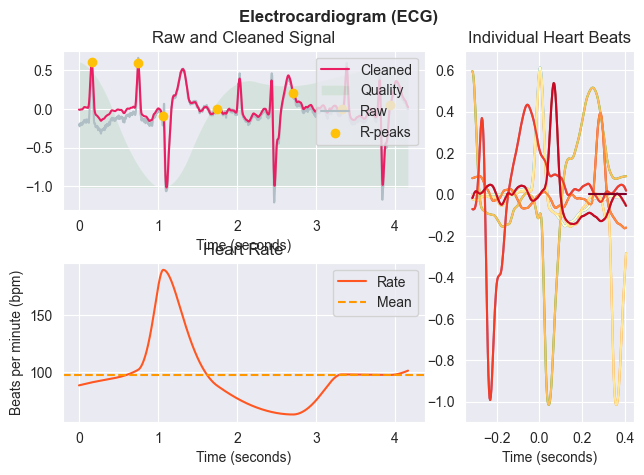

In [210]:
nk.ecg_plot(ecg_signals[i_start: i_end].reset_index(), sampling_rate=record.fs)

In [ ]:
for subject_id in afib_subjects:
    record, annotation = dataset[subject_id]

    plot_first_n_samples(record, annotation, n_samples=3000)
    fig_dir = os.path.expanduser(f'~/Downloads/first_3000_samples_{record.record_name}_AFIB.png')
    plt.savefig(fig_dir, dpi=300, bbox_inches='tight')

for subject_id in afl_subjects:
    record, annotation = dataset[subject_id]

    plot_first_n_samples(record, annotation, n_samples=3000)
    fig_dir = os.path.expanduser(f'~/Downloads/first_3000_samples_{record.record_name}_AFL.png')
    plt.savefig(fig_dir, dpi=300, bbox_inches='tight')